# Retrieve spectra using Simple Spectral Access protocol

This notebook is one of a set produced by NAVO to demonstrate data access with python tools. 

In this notebook, we show how to search for and retrieve spectra from VO services using the Registry and the __[Simple Spectral Access](http://www.ivoa.net/documents/SSA/)__ (SSA) protocol.


In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import requests, io

from astropy.table import Table
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
# For downloading files
from astropy.utils.data import download_file

import pyvo as vo

# There are a number of relatively unimportant warnings that show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore", module="astropy.io.votable.*")
warnings.filterwarnings("ignore", module="pyvo.utils.xml.*")

## Finding available Spectral Access Services

First, we find out what spectral access services ('ssa') are available in the Registry offering x-ray data.

In [2]:
services = vo.regsearch(servicetype='ssa',waveband='x-ray')
services.to_table()['ivoid','short_name']

ivoid,short_name
object,object
ivo://nasa.heasarc/chanmaster,Chandra
ivo://nasa.heasarc/intbsc,INTEGRAL/BSC
ivo://ned.ipac/sed_data_near_position,NED/SED
ivo://wfau.roe.ac.uk/heavens_at_isdc/light-curves,HEAVENS @ ISDC


We can look at only the Chandra entry:

In [3]:
chandra_service = [s for s in services if 'Chandra' in s.short_name][0] 
chandra_service.access_url

'https://heasarc.gsfc.nasa.gov/xamin/vo/ssa?table=chanmaster&'

## Chandra Spectrum of Delta Ori

Getting the list of spectra.

In [4]:
delori = SkyCoord.from_name("Delta Ori")

spec_tables = chandra_service.search(pos=delori,diameter=0.1)
spec_tables.to_table().show_in_notebook()

idx,obsid,status,name,ra,dec,time,detector,grating,exposure,type,pi,public_date,SSA_start_time,SSA_tmid,SSA_stop_time,SSA_duration,SSA_coord_obs,SSA_ra,SSA_dec,SSA_title,SSA_reference,SSA_datalength,SSA_datamodel,SSA_instrument,SSA_publisher,SSA_format,SSA_fov,SSA_wavelength_min,SSA_wavelength_max,SSA_bandwidth,SSA_bandpass
,,,,deg,deg,mjd,,,s,,,mjd,mjd,mjd,mjd,s,deg,deg,deg,,,,,,,,deg,meter,meter,meter,meter
0,639,archived,DELTA ORI,83.00125,-0.29917,51556.1364,ACIS-S,HETG,49680,GO,Cassinelli,52037,51556.136400463,51556.43650057151,51556.735856340485,49680.0,--,83.00125,-0.29917,acisf00639N004_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao01/cat2/639/primary/acisf00639N004_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
1,7416,archived,delta Ori HD 36486,83.00167,-0.29908,54413.427,HRC-S,LETG,97080,GO,Raassen,54783,54413.4270486111,54413.99748095434,54414.56715379722,97080.0,--,83.00167,-0.29908,hrcf07416N003_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao08/cat2/7416/primary/hrcf07416N003_pha2.fits.gz,2.0,Spectrum-1.0,HRC-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
2,14567,archived,Delta Ori,83.00167,-0.29908,56280.7037,ACIS-S,HETG,116500,GO,Corcoran,56647,56280.7036921296,56281.38982472211,56282.07517784063,116500.0,--,83.00167,-0.29908,acisf14567N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14567/primary/acisf14567N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
3,14568,archived,Delta Ori,83.00167,-0.29908,56288.1612,ACIS-S,HETG,123600,GO,Corcoran,56655,56288.1612268519,56288.89025076302,56289.61850203206,123600.0,--,83.00167,-0.29908,acisf14568N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14568/primary/acisf14568N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
4,14569,archived,Delta Ori,83.00167,-0.29908,56283.254,ACIS-S,HETG,120850,GO,Corcoran,56650,56283.2539814815,56283.96498017049,56284.67520199699,120850.0,--,83.00167,-0.29908,acisf14569N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14569/primary/acisf14569N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09
5,14570,archived,Delta Ori,83.00167,-0.29908,56285.5508,ACIS-S,HETG,124100,GO,Corcoran,56652,56285.5507986111,56286.28389746857,56287.016223824656,124100.0,--,83.00167,-0.29908,acisf14570N002_pha2,https://heasarc.gsfc.nasa.gov/FTP/chandra/data/science/ao14/cat2/14570/primary/acisf14570N002_pha2.fits.gz,12.0,Spectrum-1.0,ACIS-S,HEASARC,application/fits,0.81,1.2398e-10,6.1992e-09,6.07522e-09,3.16159e-09


Accessing one of the spectra.

In [5]:
## If you only run this once, you can do it in memory in one line:
##  This fetches the FITS as an astropy.io.fits object in memory
# hdu_list = spec_tables[0].getdataobj()
## But if you might run this notebook repeatedly with limited bandwidth, 
##  download it once and cache it.  
file_name = download_file(spec_tables[0].getdataurl(),cache=True)
hdu_list = fits.open(file_name)

## Simple example of plotting a spectrum

In [6]:
spec_table = Table(hdu_list[1].data)
spec_table

SPEC_NUM,TG_M,TG_PART,TG_SRCID,X,Y,CHANNEL [8192],COUNTS [8192],STAT_ERR [8192],BACKGROUND_UP [8192],BACKGROUND_DOWN [8192],BIN_LO [8192],BIN_HI [8192]
int16,int16,int16,int16,float32,float32,int16,int16,float32,int16,int16,float64,float64
1,-3,1,1,4102.815,4131.828,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
2,-2,1,1,4102.815,4131.828,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
3,-1,1,1,4102.815,4131.828,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
4,1,1,1,4102.815,4131.828,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,21.477500000001772 .. 1.0,21.480000000001773 .. 1.0025
5,2,1,1,4102.815,4131.828,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,10.738750000000886 .. 0.5,10.740000000000887 .. 0.50125
6,3,1,1,4102.815,4131.828,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,7.159166666667378 .. 0.3333333333333333,7.160000000000712 .. 0.33416666666666667
7,-3,2,1,4102.815,4131.828,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,13.985000000001373 .. 0.3333333333333333,13.98666666666804 .. 0.33499999999999996
8,-2,2,1,4102.815,4131.828,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,20.977500000001505 .. 0.5,20.980000000001507 .. 0.5025
9,-1,2,1,4102.815,4131.828,1 .. 8192,0 .. 0,1.8660254 .. 1.8660254,0 .. 0,0 .. 0,41.95500000000301 .. 1.0,41.960000000003014 .. 1.005


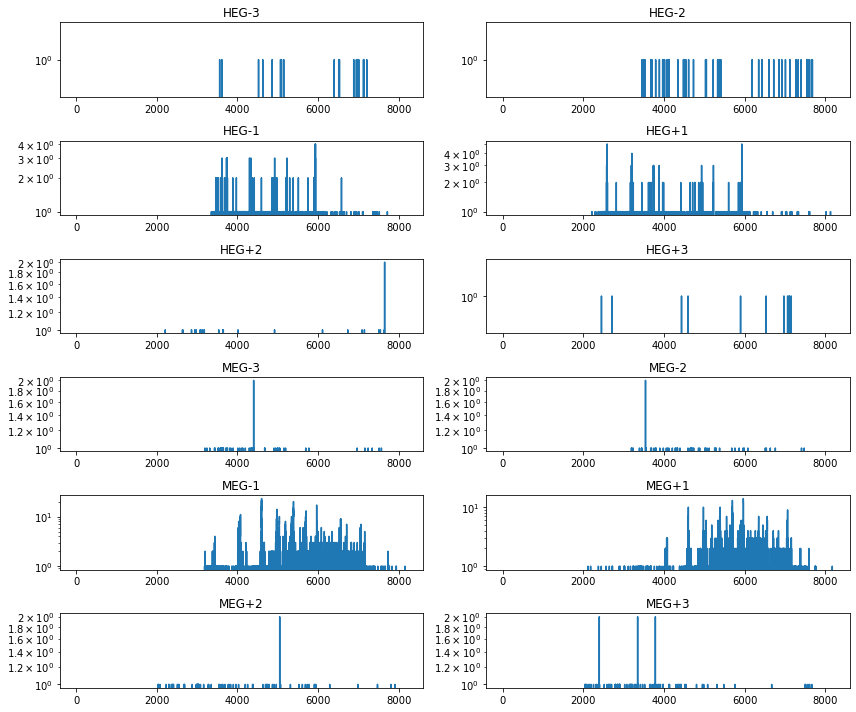

In [7]:
matplotlib.rcParams['figure.figsize'] = (12, 10)

for i in range(len(spec_table)): 
    
    ax = plt.subplot(6,2,i+1)
    pha = plt.plot( spec_table['CHANNEL'][i],spec_table['COUNTS'][i])
    ax.set_yscale('log')
    
    if spec_table['TG_PART'][i] == 1:
        instr='HEG'
    if spec_table['TG_PART'][i] == 2:
        instr='MEG'
    if spec_table['TG_PART'][i] == 3:
        instr='LEG'
        
    ax.set_title("{grating}{order:+d}".format(grating=instr, order=spec_table['TG_M'][i]))
    
    plt.tight_layout()

This can then be analyzed in your favorite spectral analysis tool, e.g., [pyXspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html).  (For the winter 2018 AAS workshop, we demonstrated this in a [notebook](https://github.com/NASA-NAVO/aas_workshop_2018/blob/master/heasarc/heasarc_Spectral_Access.ipynb) that you can consult for how to use pyXspec, but the pyXspec documentation will have more information.)  